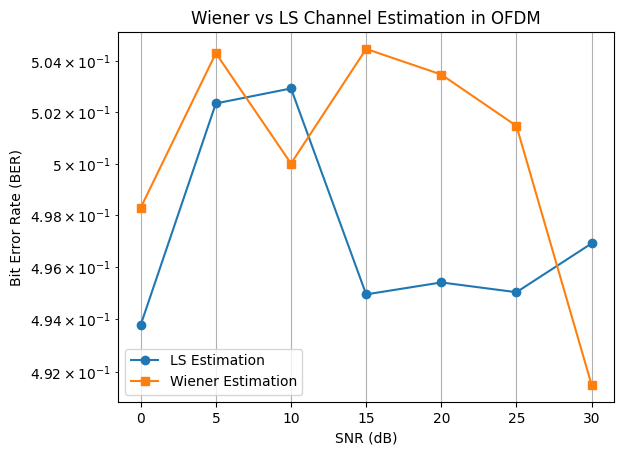

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.signal import convolve

# Parameters
N = 64  # Number of subcarriers
CP = 16  # Cyclic Prefix length
M = 4  # QAM Modulation order
num_symbols = 500  # Number of OFDM symbols
pilot_spacing = 4  # Pilot every 4th subcarrier
pilot_indices = np.arange(0, N, pilot_spacing)
data_indices = np.setdiff1d(np.arange(N), pilot_indices)
SNR_dB = np.arange(0, 35, 5)

pilot_symbol = 1 + 1j  # Known pilot symbol
ber_ls = np.zeros(len(SNR_dB))
ber_wiener = np.zeros(len(SNR_dB))

# Channel autocorrelation matrix (assumed known)
R_h = toeplitz(0.9 ** np.arange(N))

# Least Squares Estimation Function
def least_squares_estimation(rx_signal, pilot_indices, pilot_symbol, noise_power):
    H_ls_pilots = rx_signal[pilot_indices] / pilot_symbol
    theta_ls = np.sum(rx_signal[pilot_indices] * H_ls_pilots) / np.sum(H_ls_pilots ** 2)
    return theta_ls * np.ones(N)

# Wiener Filter Estimation Function
def wiener_filter_estimation(rx_signal, noise_power):
    Rxx = np.correlate(rx_signal, rx_signal, mode='full') / N
    Rxx = Rxx[N-1:]
    Rxx_matrix = toeplitz(Rxx[:N])
    Rww_matrix = noise_power * np.eye(N)
    W = Rxx_matrix @ np.linalg.inv(Rxx_matrix + Rww_matrix)
    s_hat = np.convolve(rx_signal, W[0, :], mode='same')
    return s_hat[:N]  # Ensure correct shape

for snr_idx, snr in enumerate(SNR_dB):
    errors_ls = 0
    errors_wiener = 0
    total_bits = 0
    
    for _ in range(num_symbols):
        bits = np.random.randint(0, 2, len(data_indices) * int(np.log2(M)))
        data_symbols = (2 * bits - 1) + 1j * (2 * np.random.randint(0, 2, len(bits)) - 1)
        data_symbols = data_symbols[:len(data_indices)]  # Ensure proper shape
        
        ofdm_symbol = np.zeros(N, dtype=complex)
        ofdm_symbol[pilot_indices] = pilot_symbol
        ofdm_symbol[data_indices] = data_symbols
        
        # OFDM modulation
        ifft_data = np.fft.ifft(ofdm_symbol, N)
        tx_signal = np.concatenate((ifft_data[-CP:], ifft_data))
        
        # Channel model
        h_time = (np.random.randn(8) + 1j * np.random.randn(8)) / np.sqrt(16)
        rx_signal = convolve(tx_signal, h_time, mode='same')
        
        # Add noise
        noise_power = 10 ** (-snr / 10)
        noise = np.sqrt(noise_power / 2) * (np.random.randn(*rx_signal.shape) + 1j * np.random.randn(*rx_signal.shape))
        rx_signal += noise
        
        # LS Estimation
        H_est_ls = least_squares_estimation(rx_signal, pilot_indices, pilot_symbol, noise_power)
        
        # Wiener Filter Estimation
        H_est_wiener = wiener_filter_estimation(rx_signal, noise_power)
        
        # Equalization (Fix: Extract OFDM symbol from rx_signal)
        eq_ls = rx_signal[CP:N+CP] / H_est_ls
        eq_wiener = rx_signal[CP:N+CP] / H_est_wiener[:N]  # Ensure correct shape
        
        # Demodulation
        rx_bits_ls = np.real(eq_ls[data_indices]) > 0
        rx_bits_wiener = np.real(eq_wiener[data_indices]) > 0
        
        errors_ls += np.sum(bits[:len(data_indices)] != rx_bits_ls)
        errors_wiener += np.sum(bits[:len(data_indices)] != rx_bits_wiener)
        total_bits += len(data_indices)
    
    ber_ls[snr_idx] = errors_ls / total_bits
    ber_wiener[snr_idx] = errors_wiener / total_bits

# Plot results
plt.figure()
plt.semilogy(SNR_dB, ber_ls, '-o', label='LS Estimation')
plt.semilogy(SNR_dB, ber_wiener, '-s', label='Wiener Estimation')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('Wiener vs LS Channel Estimation in OFDM')
plt.legend()
plt.grid()
plt.show()


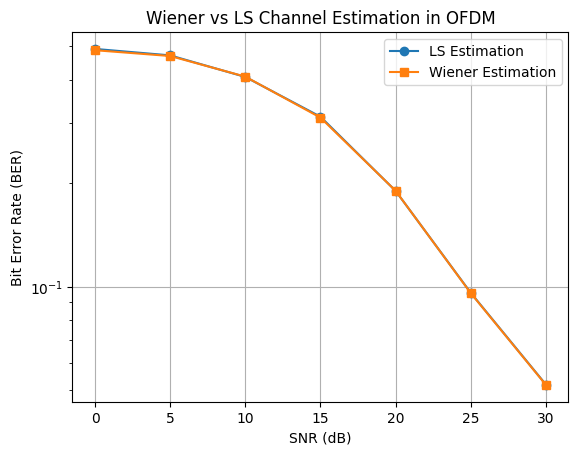

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.signal import convolve

# Parameters
N = 64  # Number of subcarriers
CP = 16  # Cyclic Prefix length
M = 16  # QAM Modulation order
num_symbols = 500  # Number of OFDM symbols
pilot_spacing = 4  # Pilot every 4th subcarrier
pilot_indices = np.arange(0, N, pilot_spacing)
data_indices = np.setdiff1d(np.arange(N), pilot_indices)
SNR_dB = np.arange(0, 35, 5)

pilot_symbol = 1 + 1j  # Known pilot symbol
ber_ls = np.zeros(len(SNR_dB))
ber_wiener = np.zeros(len(SNR_dB))

# Channel autocorrelation matrix (assumed known)
R_h = toeplitz(0.9 ** np.arange(N))
R_hh = R_h[np.ix_(pilot_indices, pilot_indices)]
R_hH = R_h[:, pilot_indices]

for snr_idx, snr in enumerate(SNR_dB):
    errors_ls = 0
    errors_wiener = 0
    total_bits = 0
    
    for _ in range(num_symbols):
        bits = np.random.randint(0, 2, len(data_indices) * int(np.log2(M)))
        data_symbols = (2 * bits - 1) + 1j * (2 * np.random.randint(0, 2, len(bits)) - 1)
        data_symbols = data_symbols[:len(data_indices)]  # Ensure proper shape
        
        ofdm_symbol = np.zeros(N, dtype=complex)
        ofdm_symbol[pilot_indices] = pilot_symbol
        ofdm_symbol[data_indices] = data_symbols
        
        # OFDM modulation
        ifft_data = np.fft.ifft(ofdm_symbol, N)
        tx_signal = np.concatenate((ifft_data[-CP:], ifft_data))
        
        # Channel model
        h_time = (np.random.randn(8) + 1j * np.random.randn(8)) / np.sqrt(16)
        rx_signal = convolve(tx_signal, h_time, mode='same')
        
        # Add noise
        noise_power = 10 ** (-snr / 10)
        noise = np.sqrt(noise_power / 2) * (np.random.randn(*rx_signal.shape) + 1j * np.random.randn(*rx_signal.shape))
        rx_signal += noise
        
        # OFDM demodulation
        rx_no_cp = rx_signal[CP:CP + N]
        rx_fft = np.fft.fft(rx_no_cp, N)
        
        # LS Estimation
        H_ls_pilots = rx_fft[pilot_indices] / pilot_symbol
        H_est_ls = np.interp(np.arange(N), pilot_indices, H_ls_pilots)
        
        # Wiener Filter Estimation
        C = R_hh + noise_power * np.eye(len(pilot_indices))
        H_est_wiener = np.dot(R_hH, np.linalg.solve(C, H_ls_pilots))
        
        # Equalization
        eq_ls = rx_fft / H_est_ls
        eq_wiener = rx_fft / H_est_wiener
        
        # Demodulation
        rx_bits_ls = np.real(eq_ls[data_indices]) > 0
        rx_bits_wiener = np.real(eq_wiener[data_indices]) > 0
        
        errors_ls += np.sum(bits[:len(data_indices)] != rx_bits_ls)
        errors_wiener += np.sum(bits[:len(data_indices)] != rx_bits_wiener)
        total_bits += len(data_indices)
    
    ber_ls[snr_idx] = errors_ls / total_bits
    ber_wiener[snr_idx] = errors_wiener / total_bits

# Plot results
plt.figure()
plt.semilogy(SNR_dB, ber_ls, '-o', label='LS Estimation')
plt.semilogy(SNR_dB, ber_wiener, '-s', label='Wiener Estimation')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('Wiener vs LS Channel Estimation in OFDM')
plt.legend()
plt.grid()
plt.show()
